In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# Classification- CIFAR10

We will be using a standard neural network to do classification on the CIFAR-10 dataset. Once we have done so, we will see how to run this network on a container in ThetaG, and then how to optimize inference using this network using NVIDIA TensorRT. The code below closely follows https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html.

# Dataset

The dataset has already been downloaded and placed in the `data_dir` directory. It was downloaded by running the
`download_data.py` script (to use this script, run it from your terminal: `python3 download_data.py`).

We now define the train and test data loaders, and define some transformations to pre-process the images. Then, we display some of the training images to get an idea of how the data looks.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

data_dir = '/lus/grand/projects/ALCFAITP/'

trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=data_dir, train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

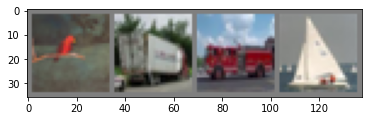

bird  truck truck ship 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Model 

Now that we have taken care of the dataset, we can define our neural network as follows:

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

We use cross-entropy loss, and use the SGD optimizer.

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

We can now train the network, printing out the loss every (say) 2000 mini-batches. We then save the model so that we can use it later. 

In [6]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.213
[1,  4000] loss: 1.851
[1,  6000] loss: 1.664
[1,  8000] loss: 1.574
[1, 10000] loss: 1.524
[1, 12000] loss: 1.461
Finished Training


In [12]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.242
[1,  4000] loss: 1.924
[1,  6000] loss: 1.715
[1,  8000] loss: 1.594
[1, 10000] loss: 1.537
[1, 12000] loss: 1.470
[2,  2000] loss: 1.420
[2,  4000] loss: 1.374
[2,  6000] loss: 1.334
[2,  8000] loss: 1.347
[2, 10000] loss: 1.295
[2, 12000] loss: 1.282
[3,  2000] loss: 1.202
[3,  4000] loss: 1.220
[3,  6000] loss: 1.200
[3,  8000] loss: 1.181
[3, 10000] loss: 1.208
[3, 12000] loss: 1.172
[4,  2000] loss: 1.086
[4,  4000] loss: 1.110
[4,  6000] loss: 1.097
[4,  8000] loss: 1.084
[4, 10000] loss: 1.093
[4, 12000] loss: 1.086
[5,  2000] loss: 1.001
[5,  4000] loss: 0.991
[5,  6000] loss: 1.027
[5,  8000] loss: 1.030
[5, 10000] loss: 1.043
[5, 12000] loss: 1.025
[6,  2000] loss: 0.929
[6,  4000] loss: 0.971
[6,  6000] loss: 0.943
[6,  8000] loss: 0.972
[6, 10000] loss: 0.979
[6, 12000] loss: 0.972
[7,  2000] loss: 0.879
[7,  4000] loss: 0.898
[7,  6000] loss: 0.916
[7,  8000] loss: 0.923
[7, 10000] loss: 0.928
[7, 12000] loss: 0.928
[8,  2000] loss: 0.843
[8,  4000] 

In [13]:
PATH = './saved_model/cifar_net_10_epochs.pth'
torch.save(net.state_dict(), PATH)

Now, we display some images from the test set along with their ground-truth labels. We then load the trained model, and ask the model to classify those very images, and see how these predictions compare with the actual ground-truth labels.

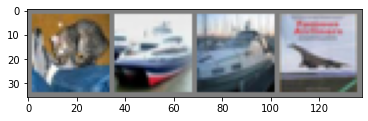

Ground Truth:  cat   ship  ship  plane


In [18]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('Ground Truth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [15]:
net = Net()
net.load_state_dict(torch.load('./saved_models/cifar_net_10_epochs.pth'))

<All keys matched successfully>

In [20]:
outputs = net(images)

In [21]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  dog   ship  ship  plane


In order to properly evaluate our model, let's run it on the entire test set, and take a look at the accuracy. We also measure the time taken to make predictions for the entire test set.

In [22]:
import time

correct = 0
total = 0
net.eval()
start_time = time.time()
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
end_time = time.time()

print(end_time-start_time)

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

12.184565782546997
Accuracy of the network on the 10000 test images: 63 %


The model's accuracy is 63%. Remember that this is a 10-way classification task- if the model had guessed randomly, it would've had only 10% accuracy. Therefore, it looks like the model has learnt some useful information about our images. See this link for the state-of-the-art accuracy on CIFAR-10: https://paperswithcode.com/sota/image-classification-on-cifar-10.

Let's now try to optimize the inference time for this model. We will then look the utility of containers, and run our model using a container. 

In [21]:
images.shape

torch.Size([4, 3, 32, 32])

In [15]:
dummy_input = torch.randn(4, 3, 32, 32)
torch_out = net(dummy_input)
input_names = [ "actual_input" ]
output_names = [ "output" ]

torch.onnx.export(net, 
                  dummy_input,
                  "./saved_models/cifar_net_10_epochs.onnx",
                  verbose=False,
                  input_names=input_names,
                  output_names=output_names,
                  export_params=True,
                  )
